# Empirical vs Theoretical Effective Cross-Section
N. Karastathis

In this notebook we make a naive approach on the "theoretical" effective cross-section on the LHC losses and we compare this with the average (among beams) observed one, visualizing the potential gain of the crossing anti-leveling scheme.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special   import erfc
from scipy.integrate import cumtrapz
from math import *
from scipy.constants import c
import matplotlib.gridspec as gridspec
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

In [4]:
#
# Calculate Luminosity
#
def luminosity(gamma=None, bx_m=None, by_m=None, enx_m=None, eny_m=None, Npart_ppb=None, nb=None, frev_hz=None, blength_s=None, phi_rad=None, experiment=None, crab=False):    

    clight = 299792458.0
    # some conversions
    xing_rad    = phi_rad/2.0
    sigz        = (blength_s/4.0)*clight
    emitGeo_x_m = enx_m/gamma
    emitGeo_y_m = eny_m/gamma
    
    # Calculate Hourglass
    u_fact    = bx_m/(sigz)
    Hourglass = np.sqrt(np.pi)*u_fact*np.exp(u_fact**2)*erfc(u_fact) 
    
    # Calculate Beam size squared 
    beam_size_squared = np.sqrt(bx_m*emitGeo_x_m)*np.sqrt(by_m*emitGeo_y_m)
    
    # Calculate Kernel
    FF = (Npart_ppb*Npart_ppb*nb*frev_hz)/(4*np.pi*beam_size_squared)

    # Calculate Geometric Factor, depending on crossing plane
    if experiment is None:
        experiment = "CMS"
        
    if experiment == 'ATLAS':
        S  = 1/np.sqrt(1+ ((sigz*xing_rad)**2)/(by_m*emitGeo_y_m) )
    elif experiment == 'CMS':
        S  = 1/np.sqrt(1+ ((sigz*xing_rad)**2)/(bx_m*emitGeo_x_m) )
    
    # Return Luminosity with crab cavities (R1/R0 ?)
    if crab:
        R1  = 0.8
        R0  = 0.285
        C   = R1/R0
        return FF*S*Hourglass*C
    
    return FF*S*Hourglass

# Choose a representative fill

In [5]:
filln = 7056

In [6]:
infolder      = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/fill_{}/'.format(filln)
lifetime_file = 'fill_{}_lifetime.pkl.gz'.format(filln)
sb_file       = 'fill_{}.pkl.gz'.format(filln)

## 1. Measured cross-section

In [7]:
with gzip.open(infolder+lifetime_file, 'rb') as fid:
    lf = pickle.load(fid)

In [8]:
xsect_mean_b1 = np.nanmean(lf[1]['losses_dndtL_bbb']*1.0e31, axis=1)
xsect_mean_b2 = np.nanmean(lf[2]['losses_dndtL_bbb']*1.0e31, axis=1)
trange = lf['time_range']

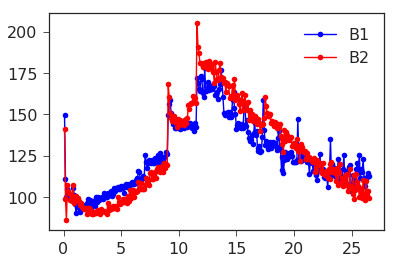

In [9]:
plt.plot((trange[1:-1]-trange[0])/3600, xsect_mean_b1[1:], 'b-o', label='B1')
plt.plot((trange[1:-1]-trange[0])/3600, xsect_mean_b2[1:], 'r-o', label='B2')
plt.legend()

# 2. Crossing Angle & $\beta^*$

In [10]:
with gzip.open(infolder+sb_file, 'rb') as fid:
    sb = pickle.load(fid)

In [11]:
xing = sb['xing_angle'][1]/2*1.0e6  # in um

In [12]:
beta = sb['betastar'][1] # in cm

# 3. Make a DF

In [13]:
# prepend a nan to xsect 
xsect_b1 = [np.nan]
for x in xsect_mean_b1:
    xsect_b1.append(x)
xsect_b1 = np.array(xsect_b1)
    
xsect_b2 = [np.nan]
for x in xsect_mean_b2:
    xsect_b2.append(x)
xsect_b2 = np.array(xsect_b2)

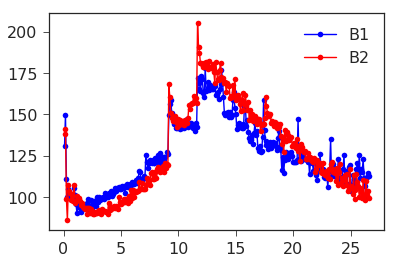

In [14]:
plt.plot((trange-trange[0])/3600, xsect_b1, 'b-o', label='B1')
plt.plot((trange-trange[0])/3600, xsect_b2, 'r-o', label='B2')
plt.legend()

In [15]:
pd.options.display.max_rows  = 20
df = pd.DataFrame()
df['timestamp']     = trange
df['seconds']     = (trange-trange[0])
df['xsect_b1'] = xsect_b1
df['xsect_b2'] = xsect_b2
df['xing']     = xing
df['beta']     = beta

In [16]:
df['avg_xsect'] = (df['xsect_b1'] + df['xsect_b2'])/2.0

In [17]:
df[df['xing']==160]

,timestamp,seconds,xsect_b1,xsect_b2,xing,beta,avg_xsect
0,1.534298e+09,0.0,NaN,NaN,160.0,30.0,NaN
1,1.534299e+09,300.0,130.632317,138.236757,160.0,30.0,134.434537
2,1.534299e+09,600.0,149.836978,141.247791,160.0,30.0,145.542385
3,1.534299e+09,900.0,110.666350,98.830265,160.0,30.0,104.748307
4,1.534300e+09,1200.0,99.809249,85.943159,160.0,30.0,92.876204


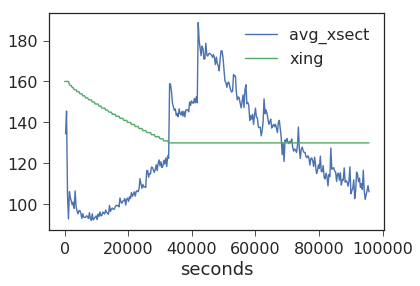

In [18]:
df.plot(x='seconds', y=['avg_xsect', 'xing' ])

In [19]:
df[['seconds', 'avg_xsect', 'xing', 'beta']].to_csv('out_7056.csv')

In [20]:
t1 = pd.Timestamp("2018-09-08 01:18:19")
t2 = pd.Timestamp("2018-09-08 13:52:13")

In [21]:
sb['b_inten_interp_coll'][1][0]

array([  1.11914340e+11,   1.13139442e+11,   1.10893019e+11, ...,
         1.11963781e+11,   1.03544580e+11,   1.07157044e+11])

In [68]:
df = pd.read_csv('out_7056.csv', header=None)

In [69]:
1500/3600.

0.4166666666666667

In [70]:
df

,0,1,2,3,4
0,0,0.0,160.000000,160.000000,30.0
1,1,300.0,140.434537,160.000000,30.0
2,2,600.0,135.542385,160.000000,30.0
3,3,900.0,104.748307,160.000000,30.0
4,4,1200.0,92.876204,160.000000,30.0
5,5,1500.0,106.167471,158.533333,30.0
6,6,1800.0,103.230750,158.000000,30.0
7,7,2100.0,101.575644,158.000000,30.0
8,8,2400.0,99.668090,157.000000,30.0
9,9,2700.0,101.058360,157.000000,30.0


In [71]:
xsec = df[2][df[1]< 1500].values

In [72]:
time= df[1][df[1]< 1500].values

In [73]:
a2, a1, a0 = np.polyfit(time, xsec, deg=2)

<IPython.core.display.Javascript object>


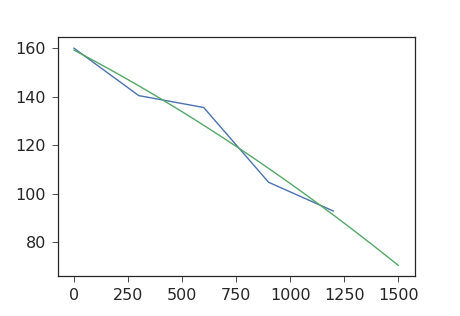

In [74]:
%matplotlib notebook
%matplotlib notebook
plt.plot(time, xsec)
t = np.linspace(0, 1500, num=1501)
plt.plot(t, a2*t**2 + a1*t + a0 )

In [75]:
minter = interp1d(df[1].values, df[3].values)

In [76]:
minter_sigma = interp1d(df[1].values, df[2].values)

In [77]:
minter(1300)

array(159.511111111)

In [82]:
#----------------------------
sigma_inelastic_m2 = 81e-31
sigma_elastic_m2   = 29.7e-31
sigma_burnOff_m2   = 90e-31
ene_tol_GeV        = 20
IBSON              = 1
#----------------------------
Nrj                = 6500.0    # GeV 
Mproton            = 0.93827231
gamma              = Nrj/Mproton
circum             = 26658.8832
clight             = 299792458.0
frev               = clight/circum;
VRF_V              = 12.0e6  # this is to use HL-LHC IBS Model
nIP                = 2.0
#----------------------------
Npart              = 1.1e11
nb                 = 2544  # Gianni suggestion 2492b
n_bunches          = 1.
bx                 = 0.30
by                 = 0.30
enx                = 2.0e-6
eny                = 2.0e-6
xing               = 160.0e-6
minXing            = 160.0e-6
bstar_init         = 0.30  # 1m
bstar_min          = 0.25 # 25cm
bstar_max          = 1.0 # 1m
changeXing         = False
phi                = 2.0*xing
minPhi             = 2.0*minXing
smoothXing         = None #2.0e-6
blength            = 1.10e-9 # 4sigma bl
levelBunchLength   = None #1.0e-9 # else None
blength_Init       = blength # else None
targetPileup       = 60.0 # assuming no changes in IRs
fill_length        = 30*3600.
turnaround_h       = 4.0 # in hours
dt_s               = 5*60. #time step in seconds
#----------------------------
# Synchrotron Radiation Times
if np.abs(Nrj-6500) < ene_tol_GeV:
    tauSRxy_s   = 64.7*3600; 
    tauSRl_s    = 32.35*3600;
elif np.abs(Nrj-7000)<ene_tol_GeV:
    tauSRxy_s   = 51.79833076*3600
    tauSRl_s    = 25.89916538*3600
#----------------------------
# Empirical Growths
emitBU = 'Model'
if emitBU=='Model':
    tau_empirical_h = 0.
    tau_empirical_v = 0.
elif emitBU=='EmpiricalBlowup':
    tau_empirical_h = 0.03e-6
    tau_empirical_v = 0.02e-6
elif emitBU=='ExtraBlowup':
    tau_empirical_h = 0.05e-6
    tau_empirical_v = 0.10e-6

tau_empirical_h1 = tau_empirical_h
tau_empirical_h2 = tau_empirical_h
tau_empirical_v1 = tau_empirical_v
tau_empirical_v2 = tau_empirical_v

#
#  STORAGE ARRAYS:
#

sav_npart          = []
sav_xing           = []
sav_instLumiATLAS  = []
sav_time           = []
sav_sigma = []
sav_intLumi = []
for t in np.arange(0,28800):
    
    #xing = minter(t)*1.0e-6
    lumi = luminosity(gamma=gamma, bx_m=0.30, by_m=0.30, enx_m=2.5e-6, eny_m=2.5e-6, Npart_ppb=Npart, nb=2544, frev_hz=frev, blength_s=1.1e-9, phi_rad=2.0*xing, experiment='ATLAS', crab=False)
    
    sav_npart.append(Npart)
    sav_time.append(t)
    sav_instLumiATLAS.append(lumi)
    sav_xing.append(xing)
    if t==0:
        sav_intLumi.append(lumi)
    else:
        sav_intLumi.append(sav_intLumi[-1]+lumi)
    
    
    if t < 1500 : 
        m_sigma = (a2*t**2 + a1*t + a0)*1.0e-31
        if m_sigma < 84e-31:
            m_sigma = 84e-31
    else:
#         m_sigma = 84e-31
        m_sigma = minter_sigma(t)*1.0e-31
        
    sav_sigma.append(m_sigma)
    
    dN = nIP*lumi/nb*m_sigma
    
    Npart = Npart-dN
print('done')

done


In [83]:
var_sav_npart          = sav_npart         
var_sav_xing           = sav_xing          
var_sav_instLumiATLAS  = sav_instLumiATLAS 
var_sav_time           = sav_time          
var_sav_sigma          = sav_sigma 
var_sav_intLumi        = sav_intLumi 

In [84]:
# const_sav_npart          = sav_npart         
# const_sav_xing           = sav_xing          
# const_sav_instLumiATLAS  = sav_instLumiATLAS 
# const_sav_time           = sav_time          
# const_sav_sigma          = sav_sigma 
# const_sav_intLumi        = sav_intLumi 

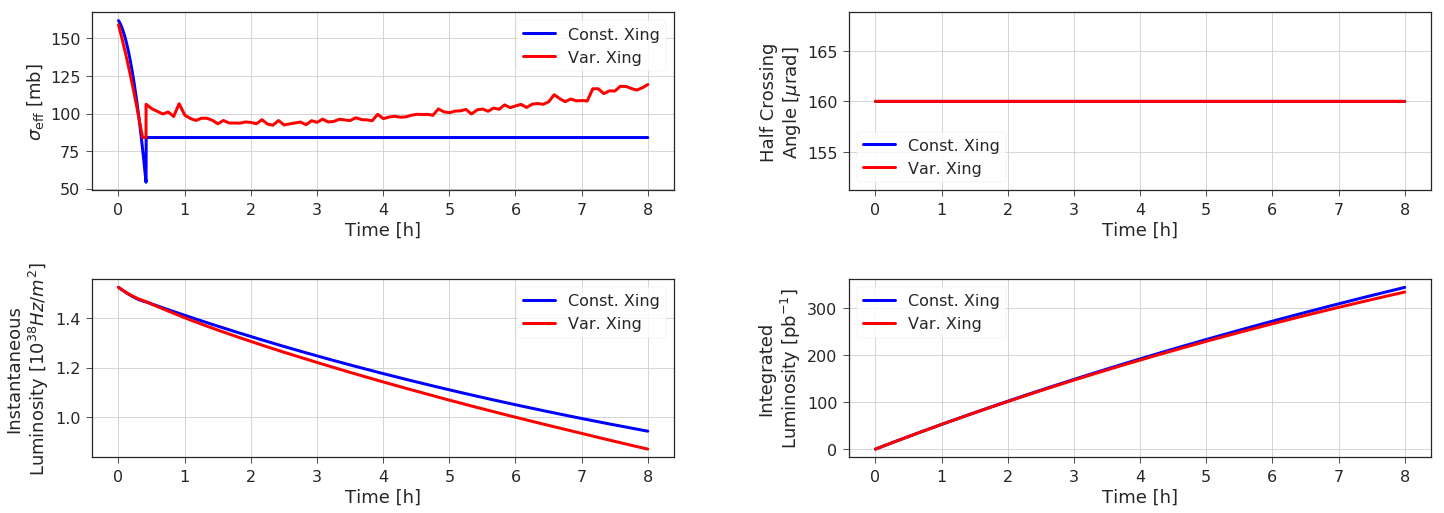

In [85]:
%matplotlib inline

f = plt.figure(1, figsize=(12*2,9*2))
ax1 = plt.subplot(421)
ax2 = plt.subplot(422, sharex=ax1)
ax3 = plt.subplot(423, sharex=ax1)
ax4 = plt.subplot(424, sharex=ax1)

ax1.plot(np.array(const_sav_time)/3600., np.array(const_sav_sigma)*1.0e31, 'b-', lw=3, label='Const. Xing' )
ax2.plot(np.array(const_sav_time)/3600., np.array(const_sav_xing)*1.0e6, 'b-', lw=3, label='Const. Xing' )
ax3.plot(np.array(const_sav_time)/3600., np.array(const_sav_instLumiATLAS)/1.0e38, 'b-', lw=3, label='Const. Xing' )
ax4.plot(np.array(const_sav_time)/3600., np.array(const_sav_intLumi)*1.0e-40, 'b-', lw=3, label='Const. Xing' )



ax1.plot(np.array(const_sav_time)/3600., np.array(var_sav_sigma)*1.0e31, 'r-', lw=3, label='Var. Xing' )
ax2.plot(np.array(const_sav_time)/3600., np.array(var_sav_xing)*1.0e6, 'r-', lw=3, label='Var. Xing' )
ax3.plot(np.array(const_sav_time)/3600., np.array(var_sav_instLumiATLAS)/1.0e38, 'r-', lw=3, label='Var. Xing' )
ax4.plot(np.array(const_sav_time)/3600., np.array(var_sav_intLumi)*1.0e-40, 'r-', lw=3, label='Var. Xing' )

ax1.set_ylabel("$\sigma_{\mathrm{eff}}$ [mb]")
ax2.set_ylabel("Half Crossing\nAngle [$\mu$rad]")
ax3.set_ylabel("Instantaneous\nLuminosity [$10^{38} Hz/m^2$]")
ax4.set_ylabel("Integrated\nLuminosity [pb$^{-1}$]")

ax1.set_xlabel("Time [h]")
ax2.set_xlabel("Time [h]")
ax3.set_xlabel("Time [h]")
ax4.set_xlabel("Time [h]")

ax1.grid('on')
ax2.grid('on')
ax3.grid('on')
ax4.grid('on')

ax1.legend(loc='upper right', fancybox=True, frameon=True)
ax2.legend(loc='lower left', fancybox=True, frameon=True)
ax3.legend(loc='upper right', fancybox=True, frameon=True)
ax4.legend(loc='upper left', fancybox=True, frameon=True)


f.subplots_adjust(hspace=0.5, wspace=0.3)

Text(0,0.5,u'Relative Gain wrt constant crossing [%]')

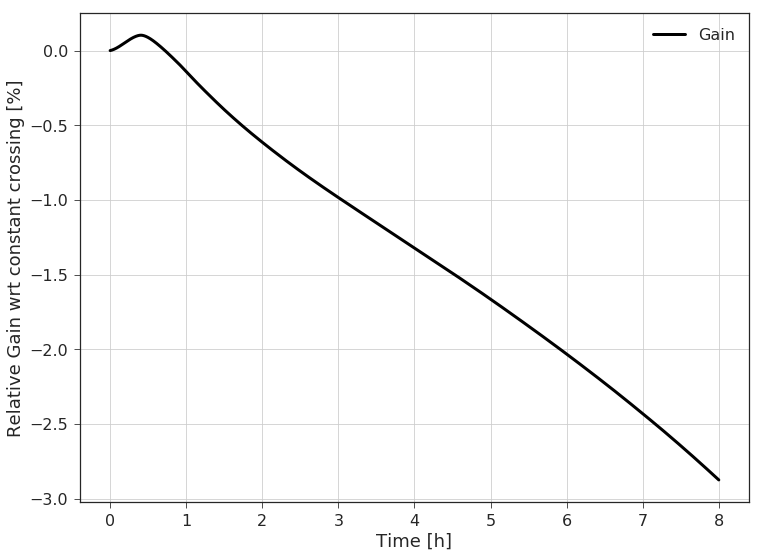

In [86]:
f = plt.figure('gain', figsize=(12,9))
ax1 = plt.subplot(111)

ax1.plot(np.array(const_sav_time)/3600.,  ((np.array(var_sav_intLumi) - np.array(const_sav_intLumi)) / np.array(const_sav_intLumi))*100.0, 'k-', lw=3, label='Gain')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Relative Gain wrt constant crossing [%]")

In [112]:
var_xing_lumi = np.array(sav_intLumi)  

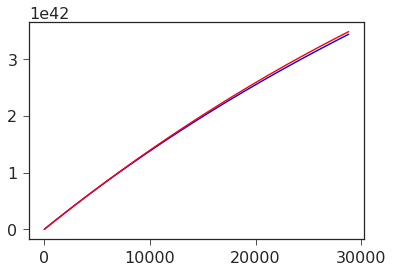

In [115]:
(var_xing_lumi[-1]/const_xing_lumi[-1])*100.

101.33665902007969